In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from utilsCPD import *
import matplotlib.pyplot as plt

BATCH_SIZE  =32
mnist_transforms = transforms.Compose([transforms.ToTensor()])
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True, transform=mnist_transforms)
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [481]:
all_batches = []
all_labels =[]
torch.manual_seed(10)
for x,y in test_dataloader:
    bs = x.shape[0]
    all_batches.append(x.flatten().reshape(bs,784))
    all_labels.append(y)

all_batches = torch.cat(all_batches,dim=0)
all_labels = torch.cat(all_labels,dim=0)



data_c1 = all_batches[all_labels==0].detach().numpy()
data_c2 = all_batches[all_labels==8].detach().numpy()


DATA = np.vstack((data_c1[:100,:],data_c2[400:600,:],data_c1[300:700,:]))

In [484]:
DATA.shape

(700, 784)

In [482]:
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

LENGHT = 50
train_dataloader_ts = DataLoader(TimeseriesDataset(DATA,LENGHT,split=0.5))
SWDs = []

calibrated = False
t = 0
skip_count = 0  # To track the number of skipped iterations
segmentation ={}
segments=0
t0=int(LENGHT*0.5)-1
for i, d in enumerate(tqdm(train_dataloader_ts)):
    # Skip iterations if `skip_count` is active
    if skip_count > 0:
        skip_count -= 1
        continue

    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    THETA = sample_theta_torch(x_ref, 1000)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=2, device=device).mean(axis=0).detach().cpu().numpy()

    SWDs.append(loss.mean())

    # Calibration phase
    if not calibrated:
        alpha_hat, beta_hat = mom_estimates(loss)
        print(f"Calibration: alpha={alpha_hat}, beta={beta_hat}")
        calibrated = True
        lower_CI = [0]
        upper_CI = [0]
        cumsum = loss.mean()
        t = 1  # Start t at 1 since we already processed one loss

    # Monitoring phase
    if calibrated:
        l, u = gamma_conf_interval(t, alpha_hat, 1 / beta_hat, 0.95)
        lower_CI.append(l)
        upper_CI.append(u)

        cumsum += loss.mean()
        t += 1

        # Check if a change point is detected
        if cumsum >= u or cumsum <= l:
            print(f"Change Alarm at iteration {i + int(LENGHT*0.5)}")
            segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*0.5),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}
            calibrated = False  # Reset calibration
            cumsum = 0
            t = 0
            skip_count = int(LENGHT*0.5)+5  # Skip the next 15 iterations
            SWDs = []
            segments+=1
            t0=i+50+5

segmentation[segments] = {'t0':t0,'t1':i+int(LENGHT*0.5),'statistic':np.cumsum(SWDs),'lower':lower_CI,'upper':upper_CI,'SWDs':SWDs}


  7%|▋         | 44/651 [00:00<00:02, 217.56it/s]

Calibration: alpha=1.0029281880500782, beta=66.51547241210938


 20%|██        | 132/651 [00:00<00:01, 382.13it/s]

Change Alarm at iteration 104
Calibration: alpha=1.6263690753036966, beta=152.08468627929688


 51%|█████     | 331/651 [00:00<00:00, 386.40it/s]

Change Alarm at iteration 297
Calibration: alpha=1.5455262059774504, beta=136.96510314941406


100%|██████████| 651/651 [00:02<00:00, 307.27it/s]


In [471]:
def plot_statistic(ax,data,ax2):
    for key in data:
        segment = data[key]
        ax2.plot(np.arange(segment['t0'],segment['t1'],1),segment['SWDs'],color='black',lw=1.0)
        ax.plot(np.arange(segment['t0'],segment['t1'],1),segment['statistic'],color='blue',lw=1.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['lower'],color='blue',lw=1,alpha=0.5)
        ax.plot(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],color='blue',lw=1,alpha=0.5)
        ax.fill_between(np.arange(segment['t0']-1,segment['t1'],1),segment['upper'],segment['lower'],color='blue',alpha=0.2)

    return ax

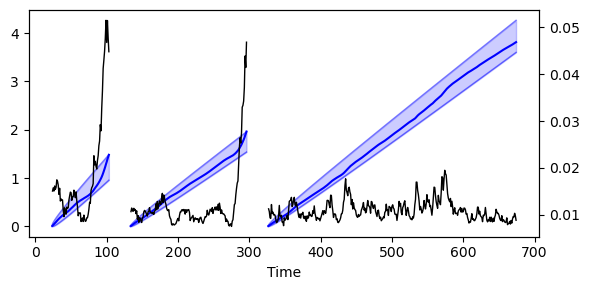

In [483]:
fig, ax = plt.subplots(figsize=(6,3))
ax2 = ax.twinx()
plot_statistic(ax,segmentation,ax2)
ax.set_xlabel('Time')
fig.tight_layout()

 12%|█▏        | 20/171 [00:00<00:00, 191.34it/s]

1.335048022141591 75.97498


 47%|████▋     | 80/171 [00:00<00:00, 241.23it/s]

Change Alarm at 95


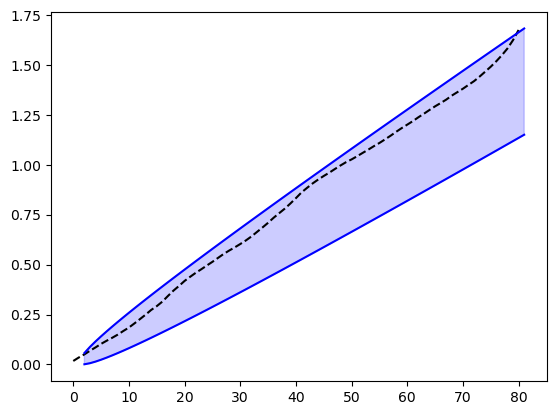

In [162]:
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader_ts = DataLoader(TimeseriesDataset(DATA,30,split=0.5))
SWDs = []

calibrated = False
t=0
for i , d in enumerate(tqdm(train_dataloader_ts)):
    x_ref, x_cur = d[0].squeeze(0).to(device),d[1].squeeze(0).to(device)
   
    THETA = sample_theta_torch(x_ref,1000)
    loss = project_and_calc_dist_torch(x_ref,x_cur,THETA,p=2,device=device).mean(axis=0).detach().cpu().numpy()

    
    
    SWDs.append(loss.mean())

    if not calibrated:
        alpha_hat,beta_hat = mom_estimates(loss)
        print(alpha_hat,beta_hat)
        calibrated = True
        lower_CI = [0]
        upper_CI  = [0]
        cumsum = loss.mean()
        t+=1

    if calibrated:
        l,u = gamma_conf_interval(i,alpha_hat,1/beta_hat,0.95)
        lower_CI.append(l)
        upper_CI.append(u)
        ###check change point
        cumsum+=loss.mean()
        if cumsum >= u or cumsum <= l:
            print("Change Alarm at {}".format(i+15))
            break
        


plt.plot(np.cumsum(SWDs),'--',color='black')
plt.plot(upper_CI,color='blue')

plt.plot(lower_CI,color='blue')
plt.fill_between(range(len(upper_CI)),upper_CI,lower_CI,color='blue',alpha=0.2);

  6%|▌         | 10/171 [00:00<00:00, 195.94it/s]

Warmup complete. Estimated parameters: alpha_hat=1.3129945745152551, beta_hat=76.23937225341797
Change Alarm at 25


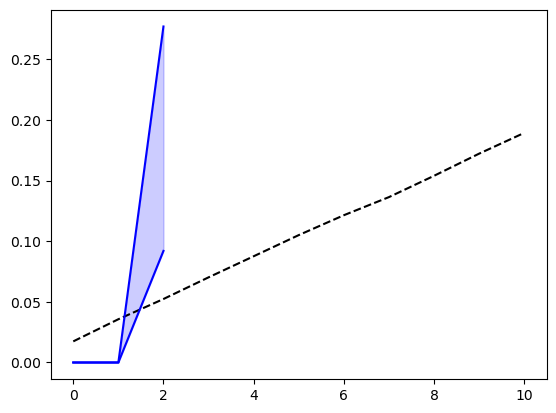

In [118]:
SWDs = []

calibrated = False
warmup = True
warmup_losses = []  # List to store losses during the warmup phase
warmup_steps = 10   # Number of steps for the warmup phase

for i, d in enumerate(tqdm(train_dataloader_ts)):
    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    THETA = sample_theta_torch(x_ref, 1000)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=2, device=device).mean(axis=0).detach().cpu().numpy()
    
    SWDs.append(loss.mean())

    if warmup and i < warmup_steps:
        # Collect losses during the warmup phase
        warmup_losses.append(loss)
        lower_CI = [0]
        upper_CI = [0]
        continue  # Skip the rest of the loop until warmup is complete
    
    if warmup and i == warmup_steps:
        # End of the warmup phase: Estimate parameters and start calibration
        warmup = False
        calibrated = True
        alpha_hat, beta_hat = mom_estimates(np.array(warmup_losses))  # Use collected warmup losses
        lower_CI.append(0)
        upper_CI.append(0)
        cumsum = np.mean(warmup_losses)  # Initialize cumulative sum with warmup mean
        print(f"Warmup complete. Estimated parameters: alpha_hat={alpha_hat}, beta_hat={beta_hat}")

    if calibrated:
        l, u = gamma_conf_interval(i , alpha_hat, 1 / beta_hat, 0.95)
        lower_CI.append(l)
        upper_CI.append(u)
        ### Check change point
        cumsum += loss.mean()
        if cumsum >= u or cumsum <= l:
            print(f"Change Alarm at {i + 15}")
            break


plt.plot(np.cumsum(SWDs),'--',color='black')
plt.plot(upper_CI,color='blue')

plt.plot(lower_CI,color='blue')
plt.fill_between(range(len(upper_CI)),upper_CI,lower_CI,color='blue',alpha=0.2);